In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes, svm
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

Pipeline   
1. Data loading
2. Preprocessing and encoding
3. Using model for classification (RandomForestClassifier, NaiveBayes and SVM)
4. Saving results

### Load data

In [2]:
data =  pd.read_csv("dataset/train.tsv",sep='\t',header=0)
print(data.head())
X = data['title']
y = data['is_fake']

#make sure that there is no class imbalance
print(len(y[y==0])/len(y))

                                               title  is_fake
0  Москвичу Владимиру Клутину пришёл счёт за вмеш...        1
1  Агент Кокорина назвал езду по встречке житейск...        0
2  Госдума рассмотрит возможность введения секрет...        1
3  ФАС заблокировала поставку скоростных трамваев...        0
4  Против Навального завели дело о недоносительст...        1
0.5


###  Preprocessing  (lemmatization and stop words removal)

In [25]:
import nltk
nltk.download("stopwords")
#--------#

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function
def preprocess_text(input_text):
    tokens = mystem.lemmatize(input_text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation
              and token.find('«') != -1
              and token.find('»') != -1]
    
    input_text = " ".join(tokens)
    
    return input_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dyush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'рамка акция елка желание министр наука высокий образование исполнять мечта алиса теплякова подарить красный диплом мгу'

In [26]:
preprocess_text("«Пачка гречки за прививку»: Минздрав объявил о новой акции для пенсионеров")

'рамка акция елка желание министр наука высокий образование исполнять мечта алиса теплякова подарить красный диплом мгу'

#### Stemming

In [3]:
def preprocess__stem_text(input_text):
    from nltk.stem.snowball import SnowballStemmer 
    stemmer = SnowballStemmer("russian") 
    tokens = stemmer.stem(input_text.lower())
    stemmed_text = " ".join(tokens)
    
    return stemmed_text

In [27]:
X_processed = X.apply(preprocess_text)
print(X[0])
print(X_processed[0])
df = pd.DataFrame()
df['title'] = X_processed
df.to_csv('processed text.csv')

Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы
москвич владимир клутин приходить счет вмешательство американский выборы


In [34]:
df = pd.read_csv('processed text.csv')
X = df['title']
X_processed_stemmed = X.apply(preprocess__stem_text)
print(X[0])
print(X_processed_stemmed[0])
df = pd.DataFrame()
df['title'] = X_processed_stemmed
df.to_csv('processed and stemmed text.csv')

москвич владимир клутин приходить счет вмешательство американский выборы
москвич владимир клутин приходить счет вмешательство американский выборы


#### Using both stemming and lemmatization show better f1-score results, so I will use both later

In [3]:
df = pd.read_csv('processed and stemmed text.csv')
X = df['title']

#### Train - test split    

In [4]:
X_raw_train, X_raw_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

####  TF-IDF encoding

In [5]:
vectorizer = TfidfVectorizer() # token_pattern=r"(?u)\S\S+" pattern captures words that split by whitespace only (?u)\b\w\w+\b|\»
vectors = vectorizer.fit_transform(X_raw_train)
feature_names = vectorizer.get_feature_names_out()
print(feature_names)
dense = vectors.todense()
X_train = dense.tolist()
dense = []
X_test = vectorizer.transform(X_raw_test)
#df = pd.DataFrame(denselist, columns=feature_names)

['00' '02м' '08м' ... 'яценюк' 'яшин' 'ящик']


## 1.RandomForest model:  

In [11]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

print(f1_score(y_test,y_pred))

0.7807692307692308


#### Feature importance:  

навальный      0.012443
запрещать      0.009002
россиянин      0.007381
госдума        0.007305
новый          0.006438
сборная        0.006066
россия         0.005810
выборы         0.005794
депутат        0.005789
российский     0.005256
гражданин      0.005184
байден         0.005057
рпц            0.004929
который        0.004872
лукашенко      0.004864
банк           0.004512
доллар         0.004501
житель         0.004329
обязывать      0.004266
рубль          0.004263
вводить        0.004239
миллиард       0.004215
матч           0.004165
предлагать     0.004066
первый         0.003940
весь           0.003874
сша            0.003858
выходить       0.003835
коронавирус    0.003761
компания       0.003694
dtype: float64


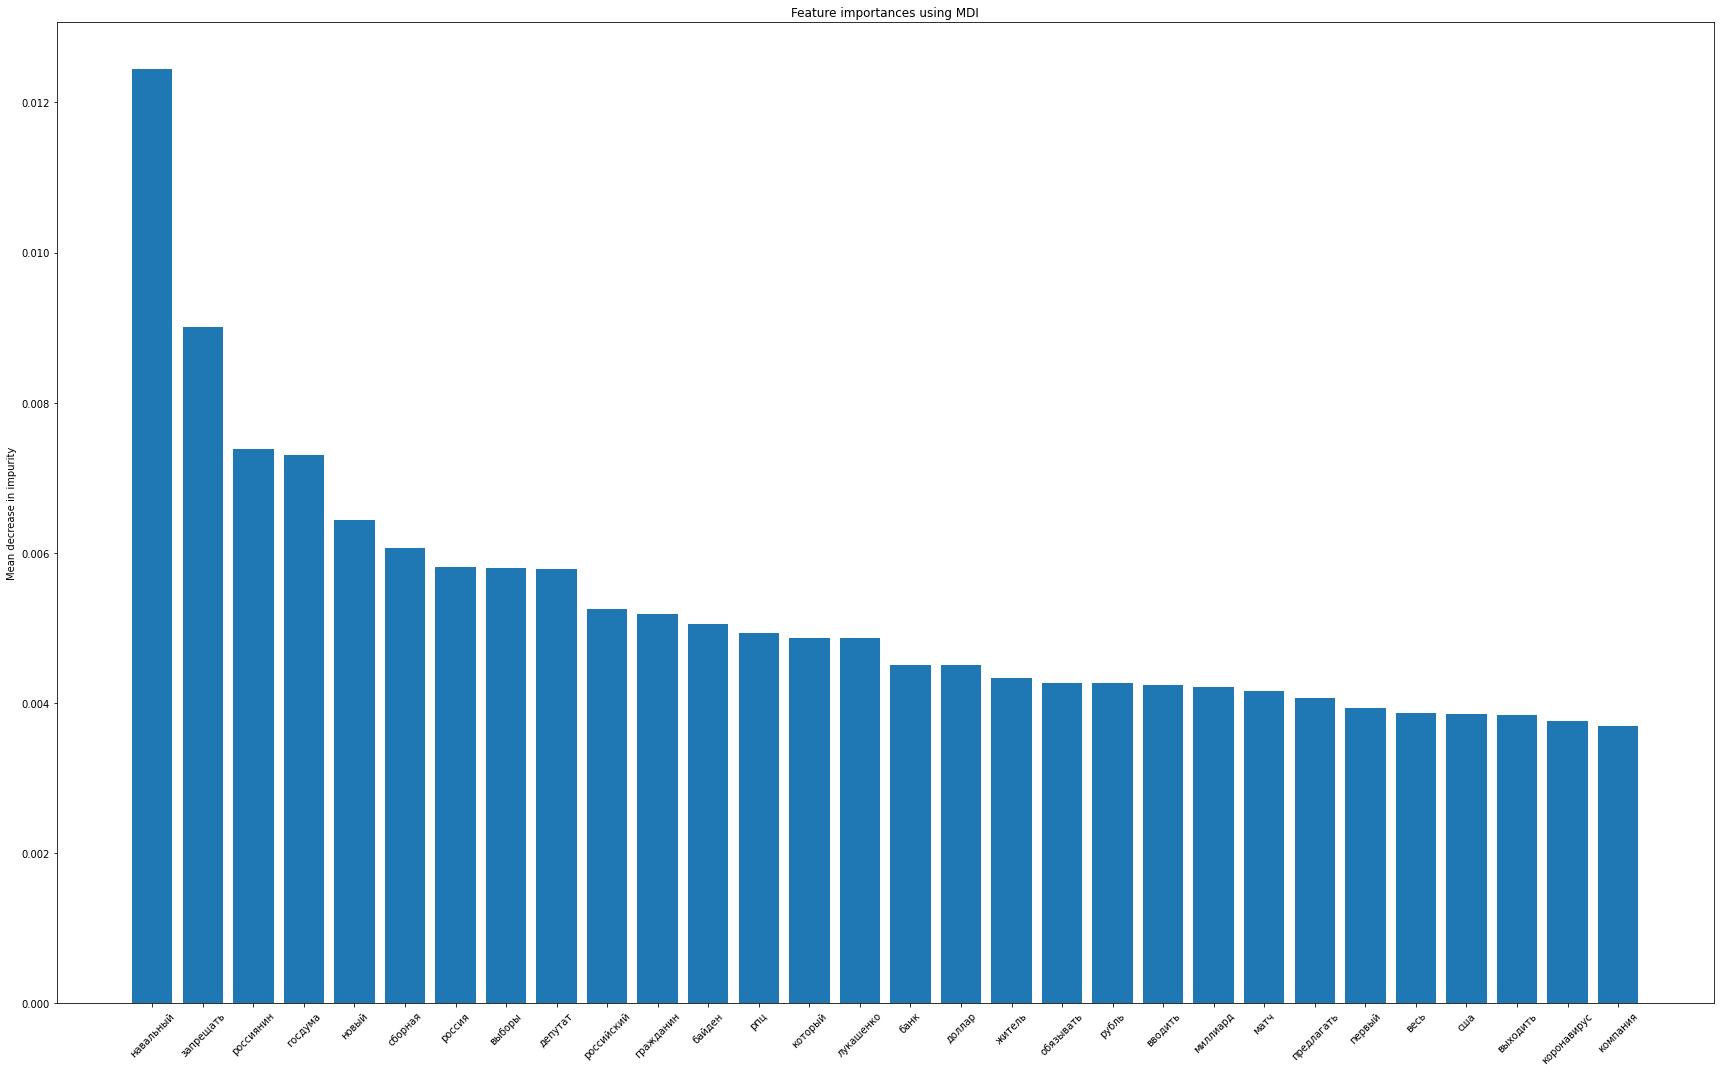

In [12]:
importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False,inplace=True)
forest_importances = forest_importances[:30]
print(forest_importances)

fig, ax = plt.subplots(figsize = (24,15))
plt.bar(x=forest_importances.index, height=forest_importances)
plt.xticks(rotation=45)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

###  Random Search  

In [53]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1400, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 20, num = 5)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 150, 
                        cv = 3, 
                        verbose = 3, 
                        random_state=0,
                        scoring='f1')
rs.fit(X_train, y_train)
rs.best_params_
joblib.dump(rs, "RFC_random_search_compressed.joblib", compress=3)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[CV 1/3] END bootstrap=True, max_depth=188, max_features=sqrt, min_samples_leaf=11, min_samples_split=18, n_estimators=350;, score=0.597 total time=   9.7s
[CV 2/3] END bootstrap=True, max_depth=188, max_features=sqrt, min_samples_leaf=11, min_samples_split=18, n_estimators=350;, score=0.650 total time=  10.0s
[CV 3/3] END bootstrap=True, max_depth=188, max_features=sqrt, min_samples_leaf=11, min_samples_split=18, n_estimators=350;, score=0.630 total time=  10.1s
[CV 1/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=11, min_samples_split=50, n_estimators=1400;, score=0.690 total time= 2.0min
[CV 2/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=11, min_samples_split=50, n_estimators=1400;, score=0.713 total time= 2.2min
[CV 3/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=11, min_samples_split=50, n_estimators=1400;, score=0.687 total time= 2.

['RF_grid_search_compressed.joblib']

In [54]:
best_clf = rs.best_estimator_
best_clf = best_clf.fit(X_train,y_train)
y_pred = best_clf.predict(X_test)
print(cross_val_score(rfc, X_train,y_train, cv=5,scoring='f1').mean())

0.8541666666666666
0.8502673796791443


#### Feature importance  

навальный     0.012192
госдума       0.008956
запрещать     0.008777
россиянин     0.006681
депутат       0.006608
выборы        0.006498
сборная       0.006437
доллар        0.006366
гражданин     0.005805
который       0.005570
миллиард      0.005466
матч          0.005322
вводить       0.004934
рпц           0.004933
байден        0.004782
лукашенко     0.004539
клуб          0.004508
из            0.004388
обязывать     0.004359
новый         0.004272
банк          0.004159
чемпионат     0.004131
за            0.004059
житель        0.003971
чемпион       0.003900
тренер        0.003891
нефть         0.003771
предлагать    0.003732
призывать     0.003705
выходить      0.003573
dtype: float64


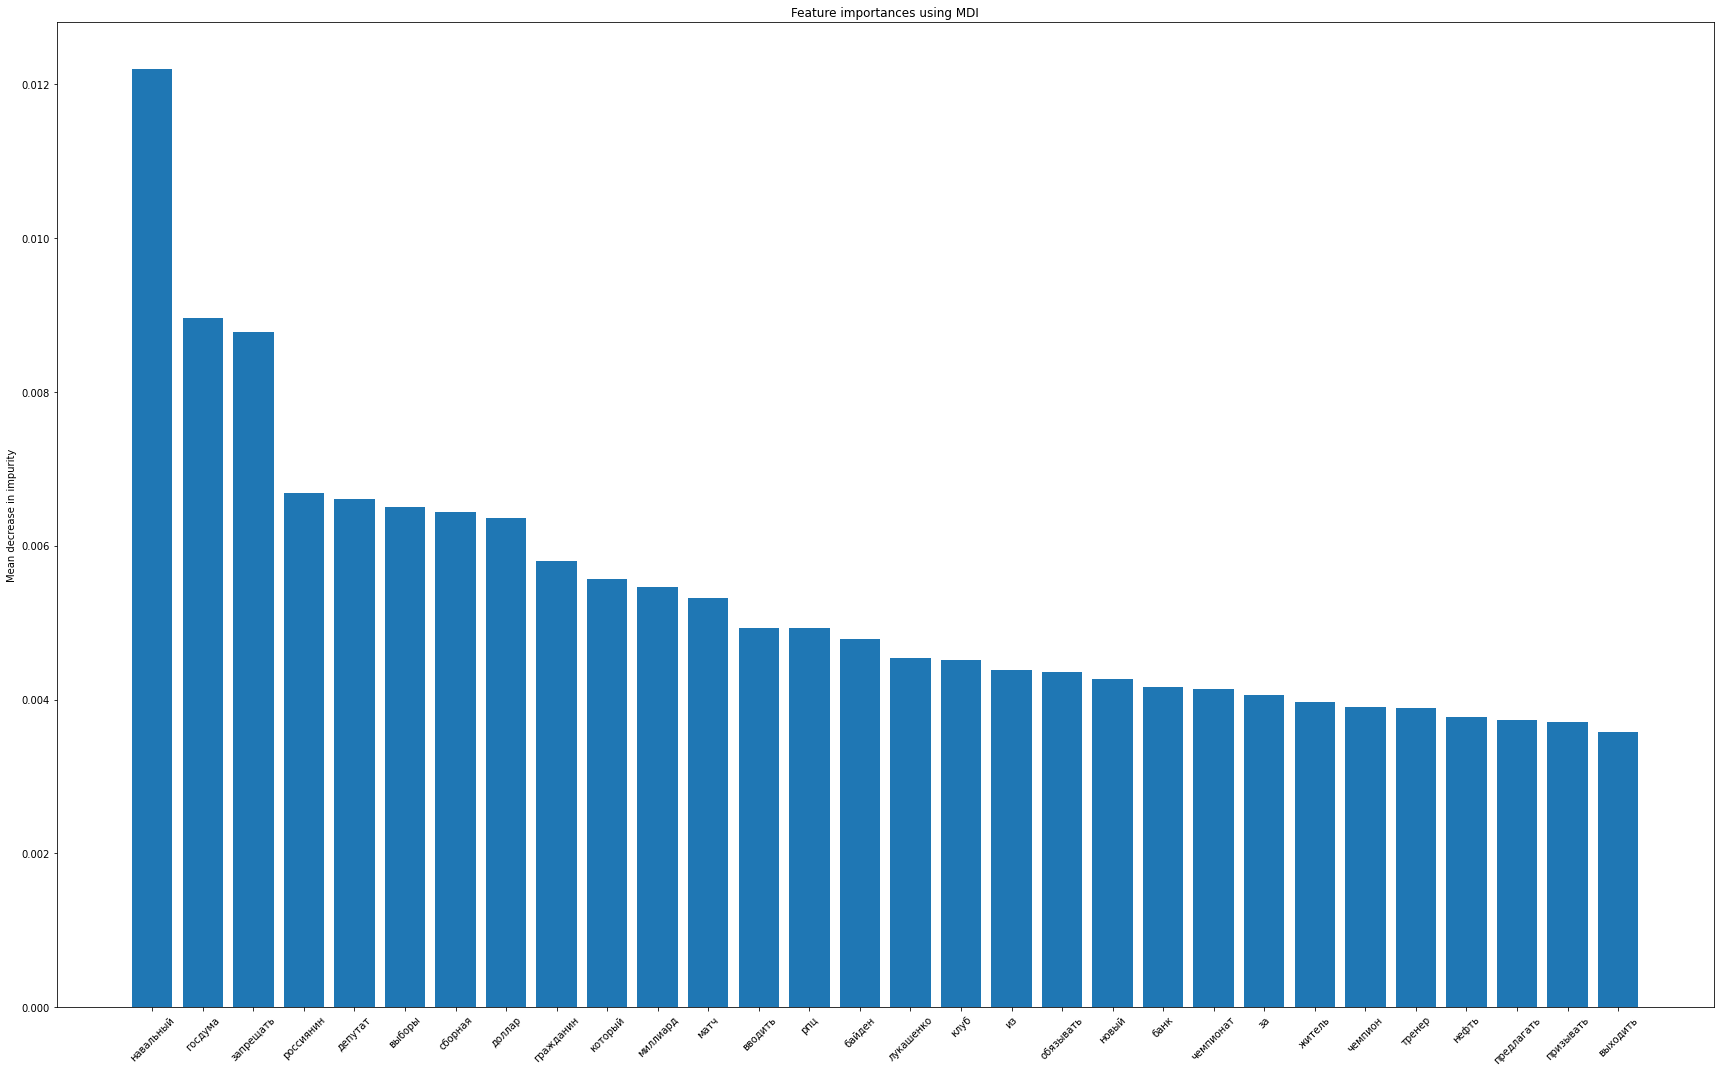

In [55]:
import matplotlib.pyplot as plt
importances = best_clf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False,inplace=True)
forest_importances = forest_importances[:30]
print(forest_importances)

fig, ax = plt.subplots(figsize = (24,15))
plt.bar(x=forest_importances.index, height=forest_importances)
plt.xticks(rotation=45)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [56]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,1400,44,2,log2,411,False,0.823582,1
1,800,12,2,log2,455,False,0.822693,2
2,1250,34,2,log2,455,False,0.822304,3
3,1250,50,2,log2,411,False,0.822304,3
4,500,23,2,log2,411,False,0.820867,5
5,500,23,2,log2,500,False,0.820867,5
6,350,34,2,log2,233,False,0.818994,7
7,200,23,2,log2,322,False,0.815689,8
8,950,18,2,log2,366,True,0.807480,9
9,350,39,2,log2,322,True,0.793019,10


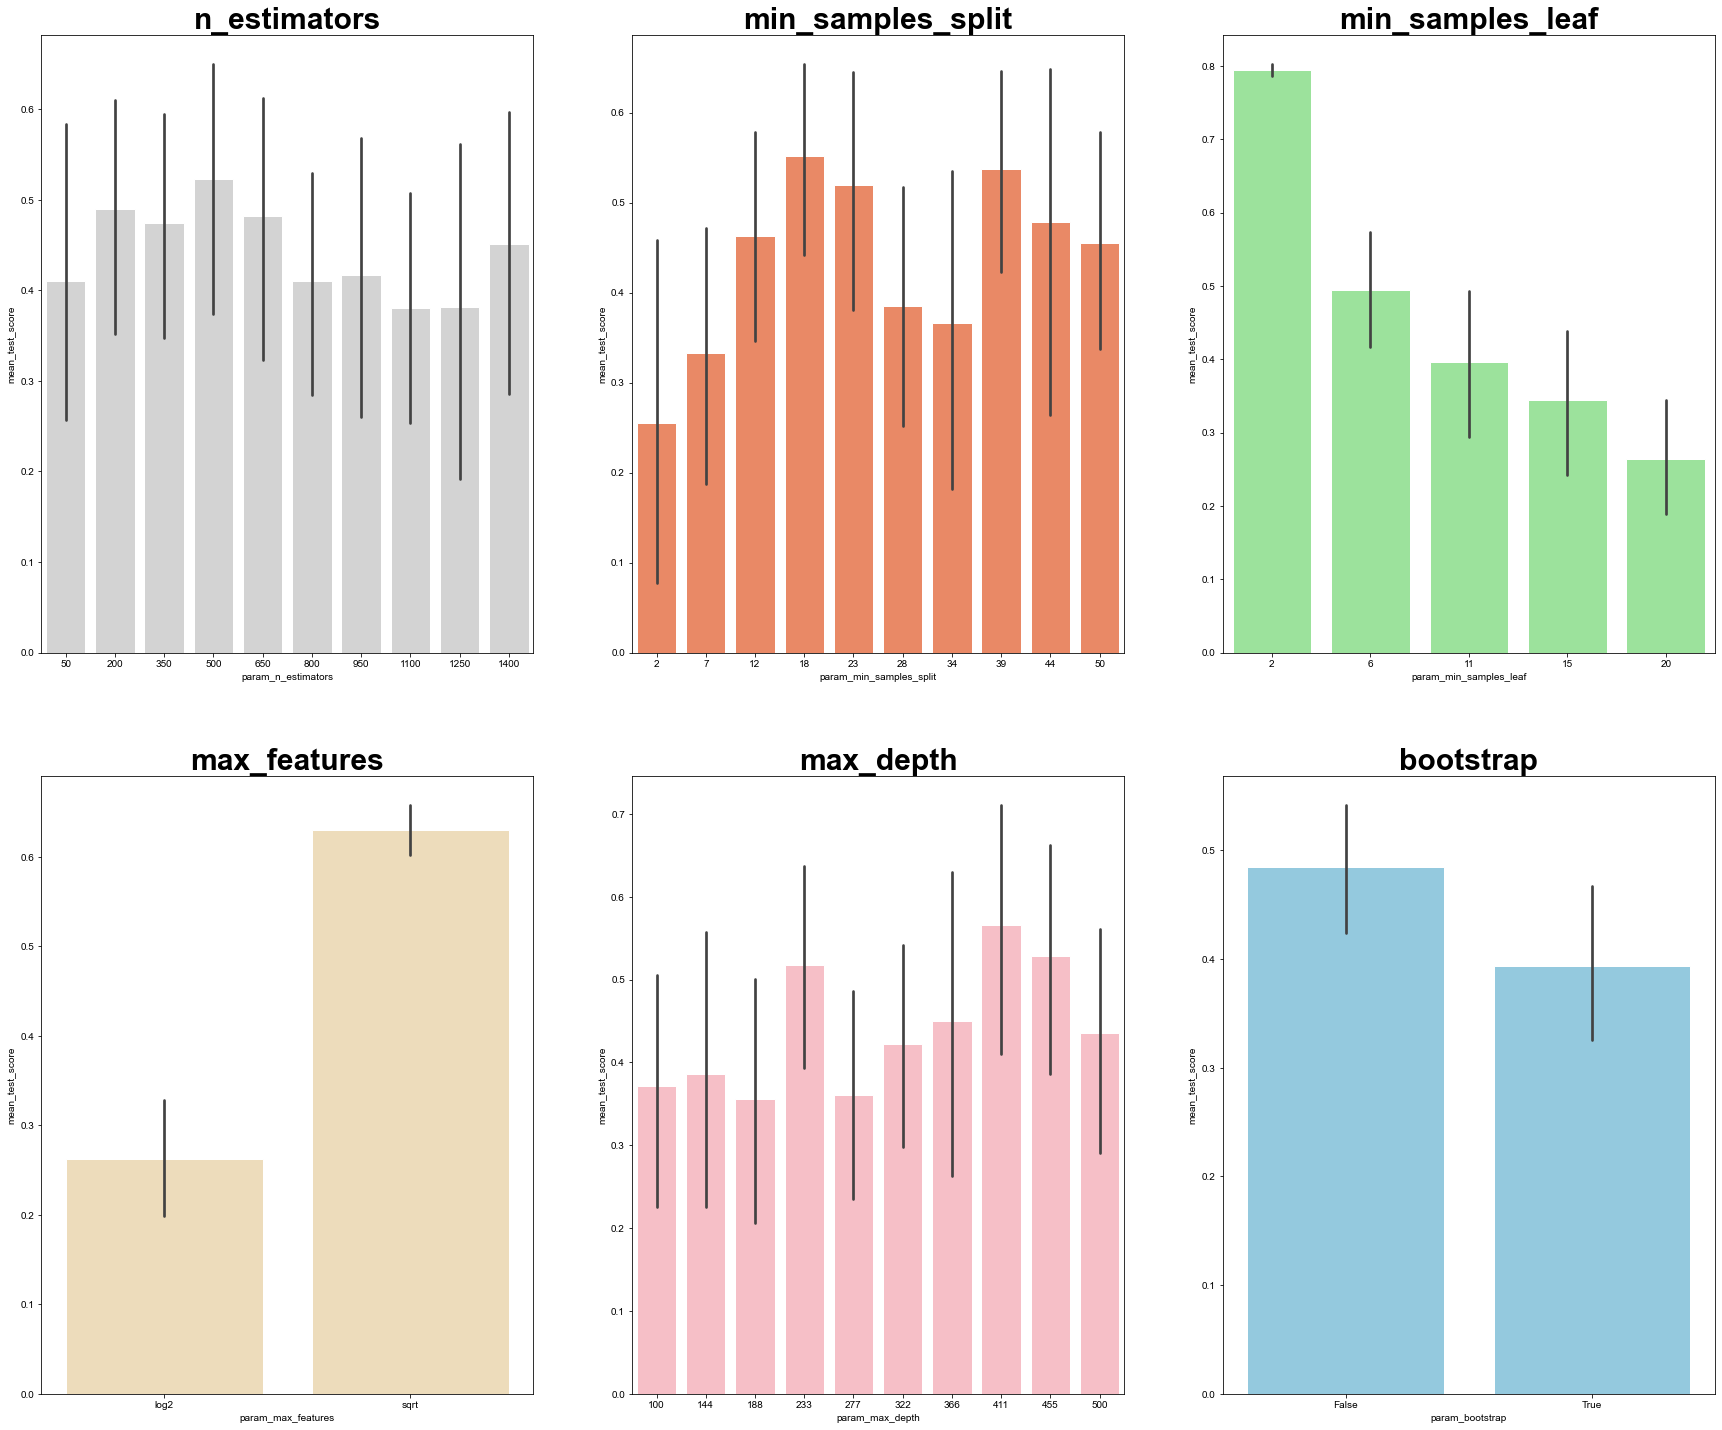

In [59]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim()
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim()
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim()
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim()
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim()
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim()
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

### Grid Search

In [13]:
clf = joblib.load("RFC_random_search_compressed.joblib", mmap_mode=None).best_estimator_
parametrs = {
    'n_estimators': [200,500,650,800,1400],
    'max_depth':[233,411,455],
    'min_samples_split':[18,39,23]
}

gs_clf = GridSearchCV(clf,parametrs,cv=3,scoring='f1',verbose=3)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_estimator_)
print(gs_clf.best_params_)
joblib.dump(gs_clf, "rfc_grid_search_compressed.joblib", compress=3)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV 1/3] END max_depth=233, min_samples_split=18, n_estimators=200;, score=0.805 total time=  14.7s
[CV 2/3] END max_depth=233, min_samples_split=18, n_estimators=200;, score=0.819 total time=  14.8s
[CV 3/3] END max_depth=233, min_samples_split=18, n_estimators=200;, score=0.823 total time=  15.2s
[CV 1/3] END max_depth=233, min_samples_split=18, n_estimators=500;, score=0.811 total time=  36.3s
[CV 2/3] END max_depth=233, min_samples_split=18, n_estimators=500;, score=0.827 total time=  36.3s
[CV 3/3] END max_depth=233, min_samples_split=18, n_estimators=500;, score=0.825 total time=  36.8s
[CV 1/3] END max_depth=233, min_samples_split=18, n_estimators=650;, score=0.819 total time=  42.8s
[CV 2/3] END max_depth=233, min_samples_split=18, n_estimators=650;, score=0.823 total time=  45.2s
[CV 3/3] END max_depth=233, min_samples_split=18, n_estimators=650;, score=0.825 total time=  47.6s
[CV 1/3] END max_depth=233, min_sample

['rfc_grid_search_compressed.joblib']

In [15]:
print(gs_clf.score(X_test,y_test))

0.8502673796791443


####  Feature importance again  

навальный     0.012193
госдума       0.008955
запрещать     0.008774
россиянин     0.006679
депутат       0.006612
выборы        0.006498
сборная       0.006435
доллар        0.006366
гражданин     0.005805
который       0.005571
миллиард      0.005464
матч          0.005324
рпц           0.004932
вводить       0.004928
байден        0.004782
лукашенко     0.004537
клуб          0.004506
из            0.004396
обязывать     0.004360
новый         0.004278
банк          0.004163
чемпионат     0.004130
за            0.004055
житель        0.003970
чемпион       0.003900
тренер        0.003892
нефть         0.003769
предлагать    0.003711
призывать     0.003705
выходить      0.003574
dtype: float64


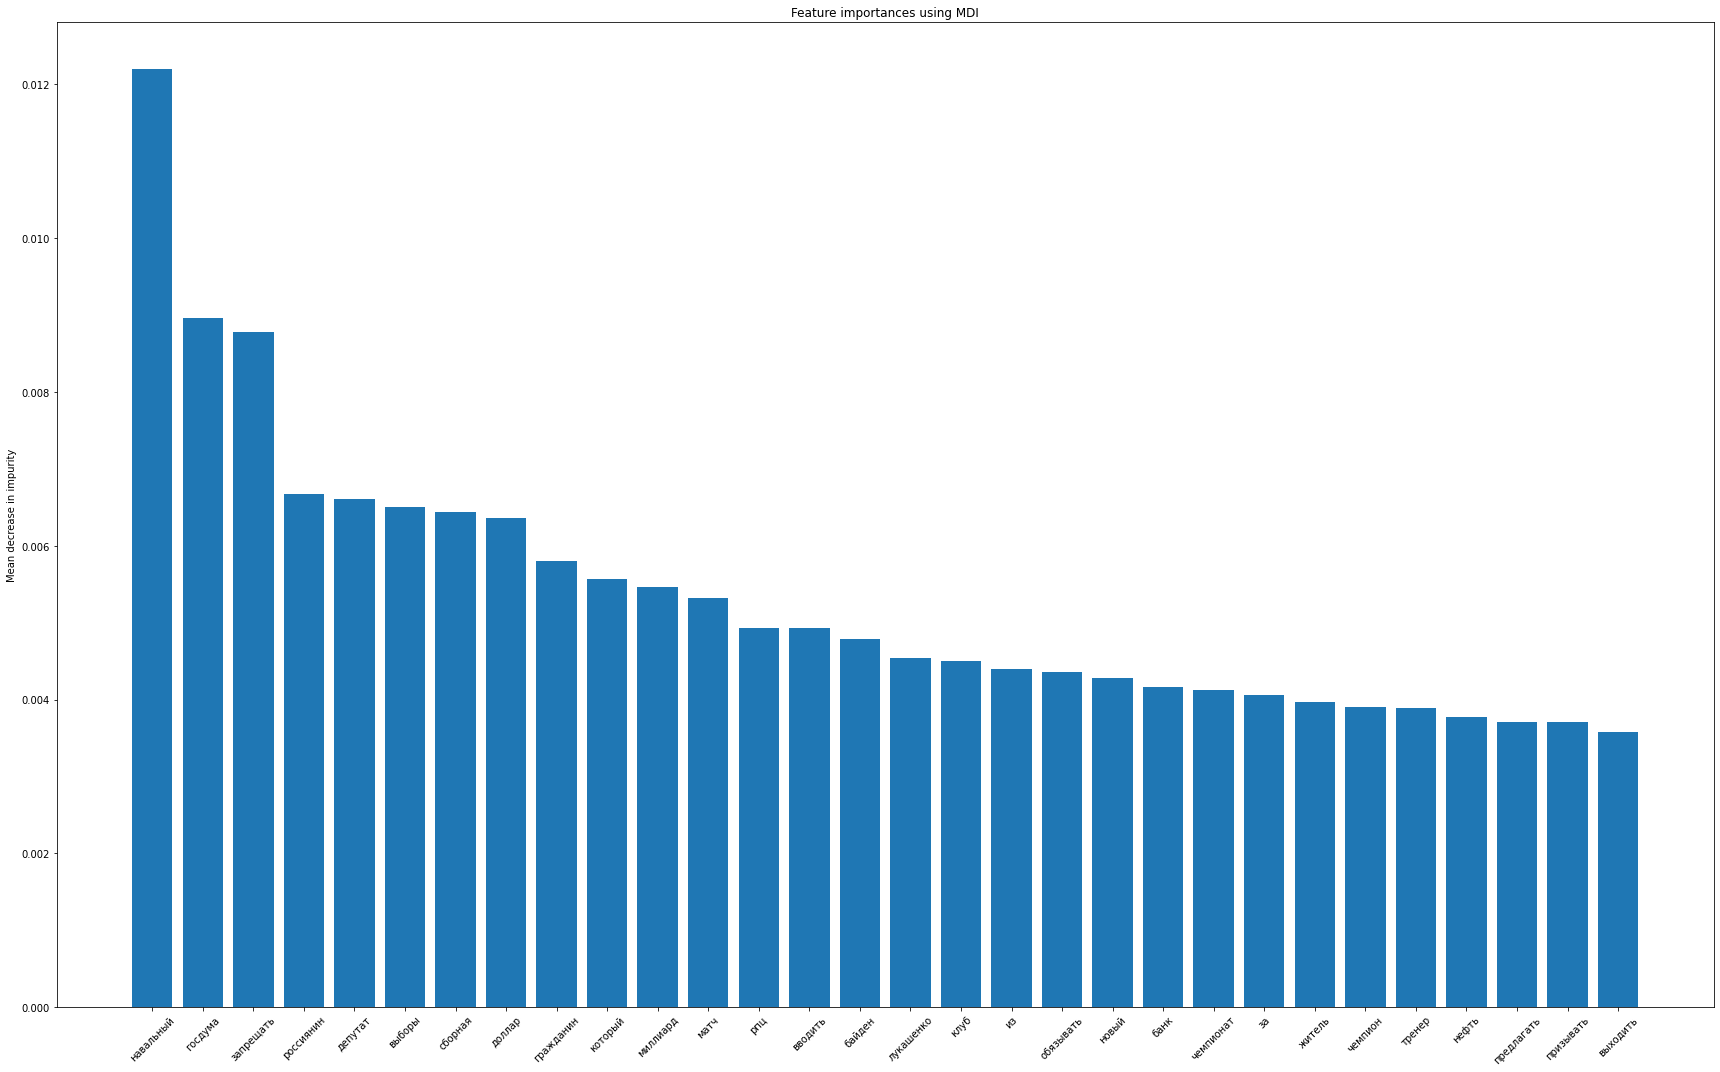

In [16]:
import matplotlib.pyplot as plt
importances = gs_clf.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False,inplace=True)
forest_importances = forest_importances[:30]
print(forest_importances)

fig, ax = plt.subplots(figsize = (24,15))
plt.bar(x=forest_importances.index, height=forest_importances)
plt.xticks(rotation=45)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 2. Support Vector Machine:

In [18]:
SVM = svm.SVC(C=1.0, kernel='linear')
SVM.fit(X_train,y_train)# predict the labels on validation dataset
y_pred = SVM.predict(X_test)
print(f1_score(y_test,y_pred))

## 3. Default naive bayes

In [ ]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,y_train)
y_pred = Naive.predict(y_train)
print(f1_score(y_test,y_pred))

0.8447189234310276


### Fine tune alpha and fit_prior params

In [ ]:
clf = Naive
parametrs = {
    'alpha':[0.001,0.05,0.01,0.5,0.75,1],
    'fit_prior':[False,True]
}

gs_mnb_clf = GridSearchCV(clf,parametrs,cv=3,scoring='f1',verbose=3)
gs_mnb_clf.fit(X_train, y_train)
print(gs_mnb_clf.best_params_)
print(gs_mnb_clf.score(X_test,y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ......alpha=0.001, fit_prior=False;, score=0.832 total time=   5.0s
[CV 2/3] END ......alpha=0.001, fit_prior=False;, score=0.810 total time=   5.4s
[CV 3/3] END ......alpha=0.001, fit_prior=False;, score=0.836 total time=   5.2s
[CV 1/3] END .......alpha=0.001, fit_prior=True;, score=0.832 total time=   5.3s
[CV 2/3] END .......alpha=0.001, fit_prior=True;, score=0.809 total time=   5.2s
[CV 3/3] END .......alpha=0.001, fit_prior=True;, score=0.836 total time=   5.3s
[CV 1/3] END .......alpha=0.05, fit_prior=False;, score=0.843 total time=   5.2s
[CV 2/3] END .......alpha=0.05, fit_prior=False;, score=0.821 total time=   5.4s
[CV 3/3] END .......alpha=0.05, fit_prior=False;, score=0.845 total time=   5.2s
[CV 1/3] END ........alpha=0.05, fit_prior=True;, score=0.841 total time=   5.6s
[CV 2/3] END ........alpha=0.05, fit_prior=True;, score=0.822 total time=   5.3s
[CV 3/3] END ........alpha=0.05, fit_prior=True;

## Make test predictions with best model  

In [109]:
data =  pd.read_csv("dataset/test.tsv",sep='\t',header=0)
print(data.head())
X_real_test = data['title']
X_real_test.head()

                                               title  is_fake
0  Роскомнадзор представил реестр сочетаний цвето...        0
1  Ночью под Минском на президентской горе Белара...        0
2  Бывший спичрайтер Юрия Лозы рассказал о трудно...        0
3  Сельская церковь, собравшая рекордно низкое ко...        0
4  Акции Google рухнули после объявления о переза...        0


0    Роскомнадзор представил реестр сочетаний цвето...
1    Ночью под Минском на президентской горе Белара...
2    Бывший спичрайтер Юрия Лозы рассказал о трудно...
3    Сельская церковь, собравшая рекордно низкое ко...
4    Акции Google рухнули после объявления о переза...
Name: title, dtype: object

####  String processing and Tf-idf again

In [ ]:
X_test_processed = X_real_test.apply(preprocess_text)
print(X_real_test[0])
print(X_test_processed[0])
df = pd.DataFrame()
df['title'] = X_test_processed
df.to_csv('processed test text.csv')

Роскомнадзор представил реестр сочетаний цветов, нежелательных в России
роскомнадзор представлять реестр сочетание цветок нежелательный россия


In [64]:
X_test_processed = pd.read_csv('processed test text.csv')['title']
X_test_processed = X_real_test.apply(preprocess__stem_text)
df.to_csv('processed stemmed test text.csv')

In [77]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(X)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
X_all = dense.tolist()
X_test = vectorizer.transform(X_test_processed)

C:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Apply model and make predictions  

In [ ]:
gs_clf_best.fit(X_all,y)

In [107]:
y_pred = gs_mnb_clf.best_estimator_.predict(X_test)

####  Wtite prediction results:  

In [110]:
data['is_fake'] = y_pred
data.to_csv("gs_best MN Bayes result.tsv",index=False)